In [ ]:
pip install pandas numpy scikit-learn matplotlib seaborn xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (assuming it's the Kaggle House Prices dataset)
# Download from: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [ ]:
# Combine train and test for consistent preprocessing
all_data = pd.concat([train.drop('SalePrice', axis=1), test], axis=0)
y_train = train['SalePrice']
print(all_data.shape)

(2919, 80)


In [ ]:
# Handle missing values
def handle_missing_values(df):
    # Numeric columns: Fill with median
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # Categorical columns: Fill with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

    return df

all_data = handle_missing_values(all_data)

# Outlier detection using IQR
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
    return df

# Apply to key numeric features
key_features = ['LotFrontage', 'LotArea', 'OverallQual', 'GrLivArea', 'GarageCars']
train_clean = train[key_features + ['SalePrice']].copy()
train_clean = remove_outliers(train_clean, key_features)
y_train = train_clean['SalePrice']
X_train_clean = train_clean.drop('SalePrice', axis=1)

# Encode categorical variables
all_data = pd.get_dummies(all_data)

# Normalize numeric features
scaler = StandardScaler()
numeric_cols = all_data.select_dtypes(include=['int64', 'float64']).columns
all_data[numeric_cols] = scaler.fit_transform(all_data[numeric_cols])

# Split back into train and test
X_train = all_data.iloc[:len(train), :]
X_test = all_data.iloc[len(train):, :]

# Align cleaned training data
X_train = X_train.loc[train_clean.index, :]

# Train-test split for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

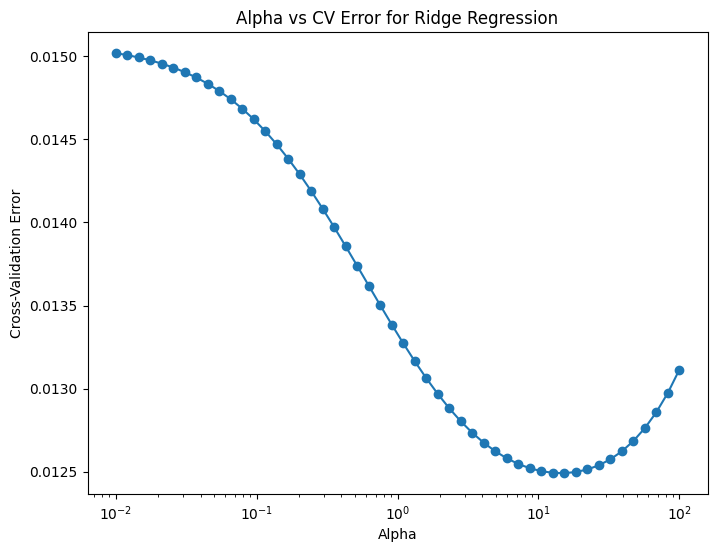

Optimal Alpha: 15.264, Minimum CV Error: 0.0125
Linear Regression MSE: 315488572.8288


In [ ]:
# Linear Regression with cross-validation for alpha (regularization)
from sklearn.linear_model import Ridge

alphas = np.logspace(-2, 2, 50)
cv_errors = []

for alpha in alphas:
    model = Ridge(alpha=alpha)
    scores = cross_val_score(model, X_train, np.log1p(y_train), scoring='neg_mean_squared_error', cv=5)
    cv_errors.append(-scores.mean())

# Plot Alpha vs CV Error
plt.figure(figsize=(8, 6))
plt.plot(alphas, cv_errors, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Error')
plt.title('Alpha vs CV Error for Ridge Regression')
plt.show()

# Optimal alpha
optimal_alpha = alphas[np.argmin(cv_errors)]
print(f"Optimal Alpha: {optimal_alpha:.3f}, Minimum CV Error: {min(cv_errors):.4f}")

# Train final model
lr_model = Ridge(alpha=optimal_alpha)
lr_model.fit(X_train_split, np.log1p(y_train_split))
lr_pred = np.expm1(lr_model.predict(X_val_split))
lr_mse = mean_squared_error(y_val_split, lr_pred)
print(f"Linear Regression MSE: {lr_mse:.4f}")

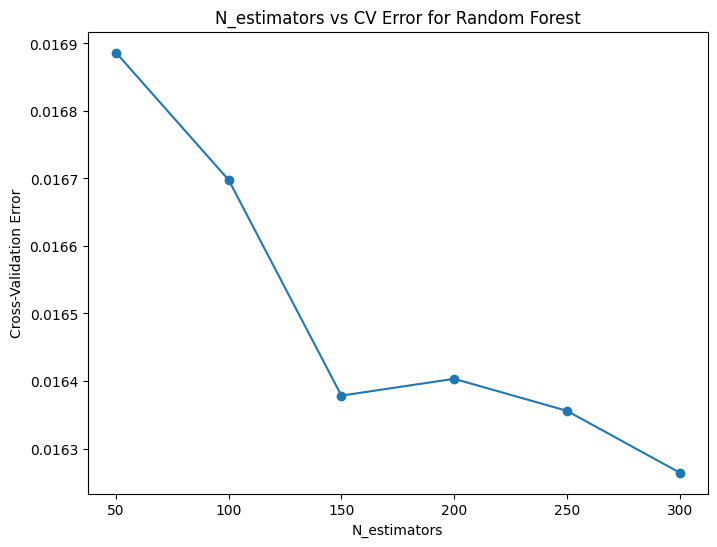

Optimal N_estimators: 300, Minimum CV Error: 0.0163
Random Forest MSE: 494597063.9509


In [ ]:
# Random Forest with cross-validation for n_estimators
n_estimators_range = range(50, 301, 50)
cv_errors_rf = []

for n in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n, max_features=0.3, random_state=42)
    scores = cross_val_score(model, X_train, np.log1p(y_train), scoring='neg_mean_squared_error', cv=5)
    cv_errors_rf.append(-scores.mean())

# Plot N_estimators vs CV Error
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_range, cv_errors_rf, marker='o')
plt.xlabel('N_estimators')
plt.ylabel('Cross-Validation Error')
plt.title('N_estimators vs CV Error for Random Forest')
plt.show()

# Optimal n_estimators
optimal_n = n_estimators_range[np.argmin(cv_errors_rf)]
print(f"Optimal N_estimators: {optimal_n}, Minimum CV Error: {min(cv_errors_rf):.4f}")

# Train final model
rf_model = RandomForestRegressor(n_estimators=optimal_n, max_features=0.3, random_state=42)
rf_model.fit(X_train_split, np.log1p(y_train_split))
rf_pred = np.expm1(rf_model.predict(X_val_split))
rf_mse = mean_squared_error(y_val_split, rf_pred)
print(f"Random Forest MSE: {rf_mse:.4f}")

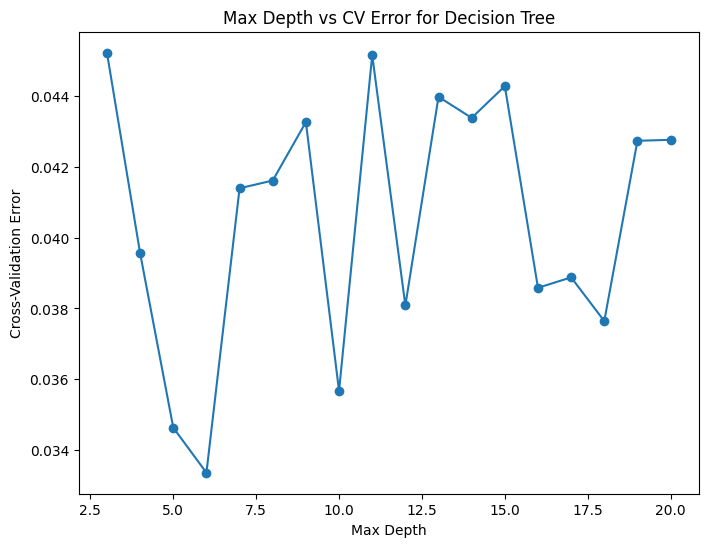

Optimal Max Depth: 6, Minimum CV Error: 0.0334
Decision Tree MSE: 1066305569.0280


In [ ]:
# Decision Tree with cross-validation for max_depth
max_depths = range(3, 21)
cv_errors_dt = []

for depth in max_depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_train, np.log1p(y_train), scoring='neg_mean_squared_error', cv=5)
    cv_errors_dt.append(-scores.mean())

# Plot Max Depth vs CV Error
plt.figure(figsize=(8, 6))
plt.plot(max_depths, cv_errors_dt, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Error')
plt.title('Max Depth vs CV Error for Decision Tree')
plt.show()

# Optimal max_depth
optimal_depth = max_depths[np.argmin(cv_errors_dt)]
print(f"Optimal Max Depth: {optimal_depth}, Minimum CV Error: {min(cv_errors_dt):.4f}")

# Train final model
dt_model = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
dt_model.fit(X_train_split, np.log1p(y_train_split))
dt_pred = np.expm1(dt_model.predict(X_val_split))
dt_mse = mean_squared_error(y_val_split, dt_pred)
print(f"Decision Tree MSE: {dt_mse:.4f}")

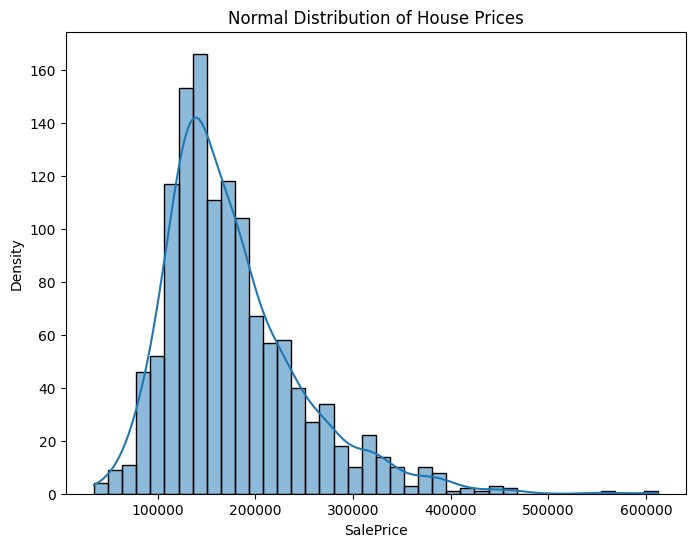

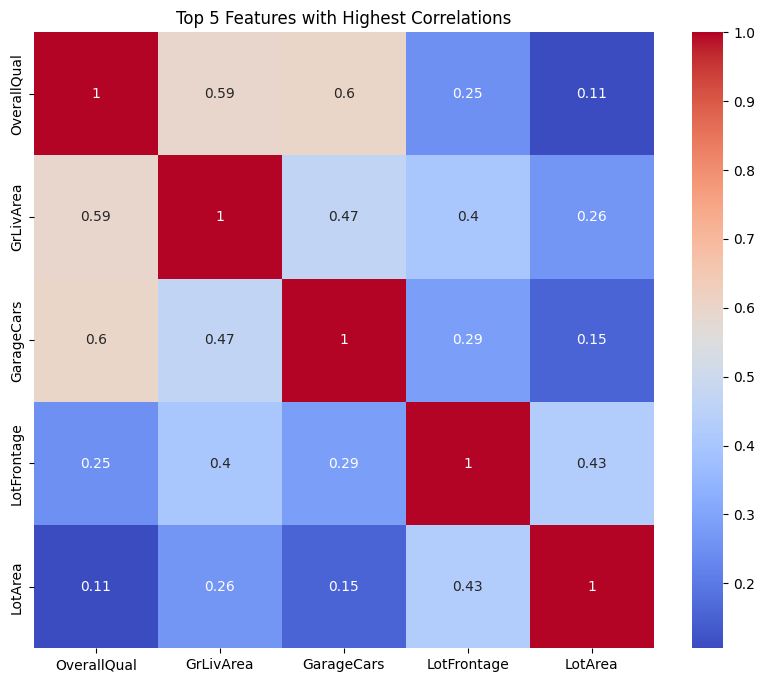

In [ ]:
# House Price Distribution
plt.figure(figsize=(8, 6))
sns.histplot(y_train, kde=True)
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Normal Distribution of House Prices')
plt.show()

# Correlation Plot for Top 5 Features
corr_matrix = train[key_features + ['SalePrice']].corr()
top_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(11).index[1:]
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm')
plt.title('Top 5 Features with Highest Correlations')
plt.show()

In [ ]:
from xgboost import XGBRegressor

# XGBoost with cross-validation for n_estimators
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_split, np.log1p(y_train_split))

# Best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
xgb_model = grid_search.best_estimator_
xgb_pred = np.expm1(xgb_model.predict(X_val_split))
xgb_mse = mean_squared_error(y_val_split, xgb_pred)
print(f"XGBoost MSE: {xgb_mse:.4f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
XGBoost MSE: 377355872.0000


In [ ]:
from sklearn.ensemble import StackingRegressor

# Define base models
base_models = [
    ('lr', Ridge(alpha=optimal_alpha)),
    ('rf', RandomForestRegressor(n_estimators=optimal_n, max_features=0.3, random_state=42)),
    ('dt', DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)),
    ('xgb', XGBRegressor(**grid_search.best_params_, random_state=42))
]

# Define meta-learner
meta_learner = LinearRegression()

# Stacking model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_learner, cv=5)
stacked_model.fit(X_train_split, np.log1p(y_train_split))
stacked_pred = np.expm1(stacked_model.predict(X_val_split))
stacked_mse = mean_squared_error(y_val_split, stacked_pred)
print(f"Stacked Model MSE: {stacked_mse:.4f}")

Stacked Model MSE: 311583949.3942


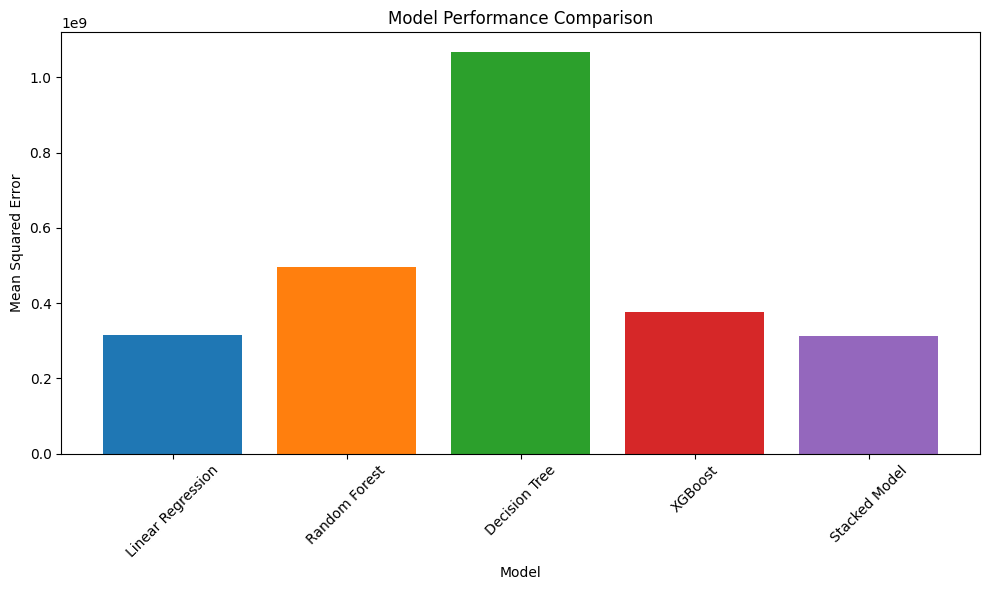

In [ ]:
# Compare MSEs
models = ['Linear Regression', 'Random Forest', 'Decision Tree', 'XGBoost', 'Stacked Model']
mses = [lr_mse, rf_mse, dt_mse, xgb_mse, stacked_mse]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mses, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()